In [1]:
%matplotlib inline

import shutil
import numpy as np
import pandas as pd
import re
import glob
import multiprocessing
import subprocess
import time
import seaborn as sns
import matplotlib.pyplot as plt

import Bio.PDB
import Bio.SeqIO
from Bio import pairwise2
from Bio.SubsMat import MatrixInfo as matlist
from Bio.SeqUtils import seq3

FACTOR=10

In [2]:
# launch pymol

import __main__
__main__.pymol_argv = ['pymol','-Qc'] # Pymol: quiet and no GUI
from time import sleep
import pymol
from pymol import cmd

pymol.finish_launching()

In [3]:
import sys
reload(sys)
sys.setdefaultencoding('utf-8')

In [4]:
# paths

hla_fasta = '../data/mhc_alleles/hla/hla_prot.fasta'
pdb_path = '../data/structures'
aligned_pdb_path = '../sandbox/aligned_pdb'
corrected_pdb_path = '../sandbox/corrected_pdb'

In [5]:
# tables

annotation = pd.read_csv('../sandbox/detailed_mhc', sep='\t')
alleles_vs_pdb = pd.read_csv('../sandbox/alleles_vs_pdb', sep='\t', index_col=0, low_memory=False)
peptides_vs_pdb = pd.read_csv('../sandbox/peptides_vs_pdb', sep='\t', index_col=0, low_memory=False)
ligand_assays = pd.read_csv('../data/epitopes/mhc_ligand_full.csv', skiprows=1, low_memory=False)

In [6]:
# table conversion

ligand_assays = ligand_assays[ligand_assays['MHC allele class'] == 'I']
affinity = ligand_assays[['Description', 'Allele Name', 'Qualitative Measure', 'Quantitative measurement']]
affinity['Length'] = [len(x) for x in affinity.Description]
affinity = affinity[(affinity.Length <= 13) & (affinity.Length >= 8)]
affinity = affinity[affinity['Allele Name'].str.contains('HLA-[ABC]\*\S+$', regex=True)]
affinity['Allele Name'] = [x[4:] for x in affinity['Allele Name']]
affinity.drop_duplicates(inplace = True)
affinity = affinity.reset_index(drop=True)

iclass = annotation[annotation.mhc_class == 'I']
iclass = iclass[iclass.a_chain_allele.str.contains('[ABC]\*', regex=True)]
iclass.a_chain_allele = [':'.join(x.split(':')[:2]) for x in iclass.a_chain_allele]
iclass = iclass.reset_index(drop=True)


In [7]:
# place mhc to the specific position
def localize_pdb(name, amhc, bmhc, pept, plen):
    # define peptide terminal CAs
    parser = Bio.PDB.PDBParser(QUIET=True)
    ppb = Bio.PDB.CaPPBuilder() 
    struct = parser.get_structure(id=name, file=pdb_path+'/'+name+'.pdb')[0]
    reslist = ppb.build_peptides(struct[pept])[0]
    firstCA = reslist[0].get_id()[1]
    lastCA = reslist[-1].get_id()[1]
    
    assert(lastCA-firstCA+1 == plen)
    
    # translate complex by -startCA
    cmd.select('sele', '%s//%s/%i/CA %s//%s/%i/CA' % (name, pept, firstCA, name, pept, lastCA))
    start, end = cmd.get_coords('sele', 1)
    cmd.translate(list(-start), name)
    
    # rotate complex around (0, 0, 0), so that endCA.y = 0
    start, end = cmd.get_coords('sele', 1)
    angle = np.arctan(end[1]/end[0])
    if end[0] < 0.0:
        angle = np.pi + angle
    angle = -angle*180.0/np.pi
    cmd.rotate('z', angle, name, origin=[0.0, 0.0, 0.0])
    
    # superpose peptide line on x axis
    start, end = cmd.get_coords('sele', 1)
    angle = np.arctan(end[2]/end[0])
    if end[0] < 0.0:
        angle = np.pi + angle
    angle = angle*180.0/np.pi
    print(cmd.rotate('y', angle, name, origin=[0.0, 0.0, 0.0]))
    
    # shift along x axis
    start, end = cmd.get_coords('sele', 1)
    print(cmd.translate([-(start[0]+end[0])/2.0, 0.0, 0.0], name))
    
    # superpose com on the xz plane
    com = cmd.centerofmass('%s//%s// %s//%s//' % (name, amhc, name, bmhc))
    angle = np.arctan(com[2]/com[1])
    if com[1] < 0.0:
        angle = np.pi + angle
    angle = -(angle)*180.0/np.pi
    print(cmd.rotate('x', angle, name, origin=[0.0, 0.0, 0.0]))
    
    # verify the result
    com = cmd.centerofmass('%s//%s// %s//%s//' % (name, amhc, name, bmhc))
    start, end = cmd.get_coords('sele', 1)
    assert(com[2] < 0.001)
    assert(start[2] < 0.001 and start[1] < 0.001)
    assert(end[2] < 0.001 and end[1] < 0.001)
    
    #cmd.delete('!(%s//%s// %s//%s// %s//%s//)' % (name, mhca, name, mhcb, name, pept))
    
    #cmd.save('../sandbox/positioned_pdb/%s_posed.pdb' % name, 
    #         '%s//%s// %s//%s// %s//%s//' % (name, mhca, name, mhcb, name, pept))
    
    sleep(0.5)

# name should be preloaded to pymol with cmd.load()    
def localize_pdb_wrapper(name, table):
    line = table[table.pdb == name].iloc[0, :]
    mhca = line['a_chain_id']
    mhcb = line['b_chain_id']
    pept = line['antigen_id']
    plen = int(line['antigen_len'])

    localize_pdb(name, mhca, mhcb, pept, plen)
    
# name should be preloaded to pymol with cmd.load()    
def clean(name, table):
    line = table[table.pdb == name].iloc[0, :]
    mhca = line['a_chain_id']
    mhcb = line['b_chain_id']
    pept = line['antigen_id']
    
    cmd.delete('!(%s//%s// %s//%s// %s//%s//)' % (name, mhca, name, mhcb, name, pept))
    
# reference and mobile should be preloaded to pymol with cmd.load()
def align_mob2ref(mob_name, ref_name, table):
    line = table[table.pdb == ref_name].iloc[0, :]
    ref_mhca = line['a_chain_id']
    ref_mhcb = line['b_chain_id']
    ref_pept = line['antigen_id']
    
    line = table[table.pdb == mob_name].iloc[0, :]
    mob_mhca = line['a_chain_id']
    mob_mhcb = line['b_chain_id']
    mob_pept = line['antigen_id']

    cmd.align('%s//%s// %s//%s//' % (mob_name, mob_mhca, mob_name, mob_pept), 
              '%s//%s// %s//%s//' % (ref_name, ref_mhca, ref_name, ref_pept))
    
# name should be preloaded to pymol with cmd.load()
def save2pdb(name, table, path):
    line = table[table.pdb == name].iloc[0, :]
    mhca = line['a_chain_id']
    mhcb = line['b_chain_id']
    pept = line['antigen_id']
    
    cmd.save(path, '%s//%s// %s//%s// %s//%s//' % (name, mhca, name, mhcb, name, pept)) 

In [8]:
def align_all_pdbs(table):
    ref=table.loc[0, 'pdb']

    cmd.reinitialize()
    cmd.load(pdb_path+'/'+ref+'.pdb', ref)
    clean(ref, table)
    localize_pdb_wrapper(ref, table)

    for i in range(1, table.shape[0]):
        name=table.loc[i, 'pdb']
        cmd.load(pdb_path+'/'+name+'.pdb', name)
        clean(name, table)
        align_mob2ref(name, ref, table)
        save2pdb(name, table, '%s/%s_aligned.pdb' % (aligned_pdb_path, name))
        cmd.delete(name)

    save2pdb(ref, table, '%s/%s_aligned.pdb' % (aligned_pdb_path, ref))
    cmd.delete(ref)
        
#align_all_pdbs(iclass)

In [9]:
# select terminal peptide CA and all atoms in range of 15 A from the peptide
def select_atoms(name, pept, plen):
    parser = Bio.PDB.PDBParser(QUIET=True)
    ppb = Bio.PDB.CaPPBuilder() 
    struct = parser.get_structure(id=name, file=corrected_pdb_path+'/'+name+'.pdb')[0]
    reslist = ppb.build_peptides(struct[pept])[0]
    firstCA = reslist[0].get_id()[1]
    lastCA = reslist[-1].get_id()[1]
    
    assert(lastCA-firstCA+1 == plen)
    
    cmd.select('fixed', '%s//%s/%i/CA %s//%s/%i/CA byres %s be. 15 of %s//%s//' % (name, pept, firstCA, 
                                                                                   name, pept, lastCA, 
                                                                                   name, name, pept))
    
    idx = []
    myspace = {'idx': idx}
    cmd.iterate_state(0, name, 'idx.append(ID)', space=myspace)  
    
    return idx

In [10]:
def ungapped_align(a, b, matrix, peptide=False):
    score = -np.inf
    pos = []
    
    if not peptide:
        for i in range(len(a) + len(b)):
            a_beg, a_end = (max(0, i-len(b)), min(i, len(a)))
            b_beg, b_end = (max(0, len(b)-i), min(len(b), len(b)+len(a)-i))

            loc_score = sum([matrix[(k, t)] for k, t in zip(a[a_beg:a_end], b[b_beg:b_end])])
            if loc_score >= score:
                    score = loc_score
                    pos = [a_beg, b_beg]
    else:
        pos = [0, 0]
    
    a_aligned = a
    b_aligned = b
    
    if (pos[0] > pos[1]):
        b_aligned = '-'*(pos[0]-pos[1])+b_aligned
    else: 
        a_aligned = '-'*(pos[1]-pos[0])+a_aligned
        
    if (len(a_aligned) > len(b_aligned)):
        b_aligned += '-'*(len(a_aligned) - len(b_aligned))
    else:
        a_aligned += '-'*(len(b_aligned) - len(a_aligned))
    
    return a_aligned, b_aligned

# s1 - mutated sequence
# s2 - reference sequence
def align(s1, s2, peptide=False):
    matrix = {}
    for key, val in matlist.blosum62.iteritems(): # do it outside the function
        matrix.update({(key[1], key[0]): val})
        matrix.update({(key[0], key[1]): val})
    
    top_aln = ungapped_align(s1, s2, matrix, peptide)

    print("\tOld: "+top_aln[0])
    print("\tNew: "+top_aln[1])
    
    # check that there is no gaps inside the alignment
    assert(re.search('[A-Z]-+[A-Z]', top_aln[0]) == None)
    assert(re.search('[A-Z]-+[A-Z]', top_aln[1]) == None)
    
    mutations = []
    gap = re.match('(-+)', top_aln[0])
    shift = 0
    if gap:
        shift = gap.end(1) - gap.start(1)
        
    for i, a1, a2 in zip(list(range(-shift, len(top_aln[0])-shift)), top_aln[0], top_aln[1]):
        if a1 != '-' and a2 != '-':
            if a1 != a2:
                mutations.append((i, a1, a2))
    return mutations

# mutate pdb structure in accordance to input sequences
# here we assume that all chains are continuous: CHECK THIS
def mutate(pdb, newseq, newpep, table):
    
    start_time = time.time()
     
    parser = Bio.PDB.PDBParser(QUIET=True)
    ppb=Bio.PDB.PPBuilder()
    
    name = pdb; 
    amhc = table[table.pdb == pdb].iloc[0, 3]
    pept = table[table.pdb == pdb].iloc[0, 7]
    b2m = table[table.pdb == pdb].iloc[0, 5]
    
    struct = parser.get_structure(id=name, file=corrected_pdb_path+'/'+name+'.pdb')[0]
    oldseq = ''.join([str(x.get_sequence()) for x in ppb.build_peptides(struct[amhc])])
    oldpep = table[table.pdb == pdb].iloc[0, 8]
    
    #print("\n0 time: " + str(time.time() - start_time)); start_time = time.time()
    
    assert(len(oldpep) == len(newpep))
    print("\n======= MHC business =======\n")
    mhc_mutations = align(oldseq, newseq)
    print("\nMHC mutations: %i\n" % len(mhc_mutations))
    
    #print("\n1 time: " + str(time.time() - start_time)); start_time = time.time()

    print("\n===== Peptide business =====\n")
    pep_mutations = align(oldpep, newpep, True)
    print("\nPeptide mutations: %i\n\n" % len(pep_mutations))
    
    #print("2 time: " + str(time.time() - start_time)); start_time = time.time()
    
    print("Mutagenesis: \n")
    # remove alternative atom locations
    cmd.remove("not alt ''+A")
    cmd.alter('all', "alt=''")
    
    # mutate
    cmd.wizard('mutagenesis')
    cmd.refresh_wizard()

    first_aa_id = ppb.build_peptides(struct[amhc])[0][0].get_id()[1]
    for i, old, new in mhc_mutations:
        print(i, old, new)
        cmd.get_wizard().do_select(amhc+'/'+str(i+first_aa_id)+'/')
        cmd.get_wizard().set_mode(seq3(new).upper())
        cmd.get_wizard().apply()
        
    first_aa_id = ppb.build_peptides(struct[pept])[0][0].get_id()[1]
    for i, old, new in pep_mutations:
        print(i, old, new)
        cmd.get_wizard().do_select(pept+'/'+str(i+first_aa_id)+'/')
        cmd.get_wizard().set_mode(seq3(new).upper())
        cmd.get_wizard().apply()
        
    cmd.set_wizard()
    
    #print("\n3 time: " + str(time.time() - start_time)); start_time = time.time()
    return (len(mhc_mutations), len(pep_mutations)) # for tests TEMPORARY

In [11]:
def peptides_rmsd(path1, chain1, path2, chain2):
    
    cmd.reinitialize()
    cmd.load(path1, 'obj1')
    cmd.load(path2, 'obj2')
    
    resi1 = []
    space = {'ar1' : resi1}
    cmd.iterate_state(0, 'obj1//%s//CA' % chain1, 'ar1.append(resi)', space=space)
    cmd.alter('obj1//%s//' % chain1, 'segi="XXX"')
    cmd.alter('obj1//%s//' % chain1, 'chain="X"')
    
    resi2 = []
    space = {'ar2' : resi2}
    cmd.iterate_state(0, 'obj2//%s//CA' % chain2, 'ar2.append(resi)', space=space)
    cmd.alter('obj2//%s//' % chain2, 'segi="XXX"')
    cmd.alter('obj2//%s//' % chain2, 'chain="X"')
    
    # alter index of each residue in each peptide to make it one-based
    shift1 = 1 - int(resi1[0])
    shift2 = 1 - int(resi2[0])
    cmd.alter('obj2/XXX/X//', 'resi=str(int(resi) + %i)' % shift2)
    cmd.alter('obj1/XXX/X//', 'resi=str(int(resi) + %i)' % shift1)
    
    cmd.remove("hydrogens")
    natom1 = cmd.count_atoms('obj2/XXX/X//')   
    natom2 = cmd.count_atoms('obj1/XXX/X//')
    print(natom1, natom2)
    #assert(natom1 == natom2)
    
    rmsd = cmd.rms_cur('obj1/XXX/X//', 'obj2/XXX/X//')
    
    cmd.delete('obj1')
    cmd.delete('obj2')

    return rmsd

In [12]:
# wrapper for mutate(..)
def find_and_mutate(path, pepseq, allele, alleledict, pep2pdb, mhc2pdb, pdb_table, first_best=10):
    
    chunk = mhc2pdb.loc[mhc2pdb.index.str.startswith(allele), :]
    best_pdbs = (chunk.apply(min) + (pep2pdb.loc[pepseq, :] / FACTOR)).sort_values().dropna()
    
    report = open(path + "/report", 'w')
    report.write('name\tpdb\ta_chain\told_allele\tnew_allele\tmhc_mutations\tpeptide_chain\
    told_peptide\tnew_peptide\tpeptide_mutations\tcompatibility_score\n')
    
    counter = 0
    for i in xrange(len(best_pdbs)):
        try:
            print("\n=============================================")    
            
            best_pdb = best_pdbs.index[i]
            comp_score = best_pdbs[best_pdb]
            
            if np.isnan(comp_score):
                print("No compatible structures found")
                break
            
            print("Operating on "+best_pdb+"\n")    
                
            allele_list = chunk.loc[:, best_pdb]
            full_allele = allele_list[allele_list == min(allele_list)].index[0]
            print("New allele: "+full_allele)
            
            alleleseq = str(alleledict[full_allele].seq)
            print('Compability score: %f' % comp_score)
            
            cmd.reinitialize()
            cmd.load(corrected_pdb_path+'/'+best_pdb+'.pdb', best_pdb)
            cmd.save(path + ("/original%i.pdb" % counter))
            
            mhc_mut_num, pep_mut_num = mutate(best_pdb, alleleseq, pepseq, pdb_table)
            line = pdb_table[pdb_table.pdb == best_pdb].iloc[0, :]
            
            mut_path = path + "/mutated%i.pdb" % counter
            cmd.save(mut_path, best_pdb)
            
            report.write("%s\t%s\t%s\t%s\t%s\t%i\t%s\t%s\t%s\t%i\t%.2f\n" % 
                         ("mutated%i.pdb" % counter, best_pdb, line.a_chain_id, line.a_chain_allele, 
                          allele, mhc_mut_num, line.antigen_id, line.antigen_seq,
                          pepseq, pep_mut_num, comp_score))
            
            cmd.delete("all")
 
        except AssertionError:
            print('Assertion error: %s, %s, %s' % (pepseq, allele, best_pdb))
            continue
    
        except pymol.CmdException:
            print('Pymol error: %s, %s, %s' % (pepseq, allele, best_pdb))
            continue
        else:
            if (counter + 1) == first_best:
                break
            else:
                counter += 1
                
    report.close()
    return

In [13]:
def find_and_mutate_test(pepseq, allele, alleledict, pep2pdb, mhc2pdb, pdb_table, first_best=10, mod=None, ref=None):
    if ref:
        print("\nChanging to "+ref+"\n")
        allele = pdb_table[pdb_table.pdb == ref]['a_chain_allele'].iloc[0]
        pepseq = pdb_table[pdb_table.pdb == ref]['antigen_seq'].iloc[0]
        
    if mod:
        print("\nChanging "+mod+"\n")
        first_best = 1
    
    if pepseq not in pep2pdb.index:
        print(pepseq + " is not found in the table. Skipping.")
        return
    
    chunk = mhc2pdb.loc[mhc2pdb.index.str.startswith(allele), :]
    #best_pdbs = (chunk.apply(min) + pep2pdb.loc[pepseq, :]/FACTOR).sort_values()
    
    best_pdbs = (chunk.apply(min).apply(lambda x: np.nan if x < 5.0 else x) + 
                 pep2pdb.loc[pepseq, :].apply(lambda x: np.nan if x < 5.0 else x) 
                 / FACTOR).sort_values().dropna()
    
    report = open('../sandbox/mutated/report', 'w')
    report.write('name\tpdb\ta_chain\told_allele\tnew_allele\tmhc_mutations\
    \tpeptide_chain\told_peptide\tnew_peptide\tpeptide_mutations\tcompatibility_score\trmsd\n')
    
    counter = 0
    for i in xrange(len(best_pdbs)):
        try:
            print("\n=============================================")    
            
            best_pdb = best_pdbs.index[i]
            
            if mod: 
                best_pdb = mod
            
            comp_score = best_pdbs[best_pdb]
            
            if np.isnan(comp_score):
                print("No compatible structures found")
                break
            
            print("Operating on "+best_pdb+"\n")    
                
            allele_list = chunk.loc[:, best_pdb]
            full_allele = allele_list[allele_list == min(allele_list)].index[0]
            print("New allele: "+full_allele)
            
            alleleseq = str(alleledict[full_allele].seq)
            print('Compability score: %f' % comp_score)
            
            cmd.reinitialize()
            
            cmd.load(corrected_pdb_path+'/'+best_pdb+'.pdb', best_pdb)
            
            mhc_mut_num, pep_mut_num = mutate(best_pdb, alleleseq, pepseq, pdb_table)
            line = pdb_table[pdb_table.pdb == best_pdb].iloc[0, :]
            
            cmd.set_name(best_pdb, "obj")
            
            mut_path = '../sandbox/mutated/mutated%i.pdb' % counter
            hla_chain = line["a_chain_id"]
            b2m_chain = line["b_chain_id"]
            pep_chain = line["antigen_id"]
            
            # manipulations with segi are needed because some 
            # chains are initially called A,B or C and it causes a bug
            cmd.alter('obj', 'segi="XZ"')
            cmd.alter('obj/XZ/%s//' % hla_chain, 'chain="A"; segi="XY"')
            cmd.alter('obj/XZ/%s//' % b2m_chain, 'chain="B"; segi="XY"')
            cmd.alter('obj/XZ/%s//' % pep_chain, 'chain="C"; segi="XY"')
            cmd.alter('obj', 'segi=""')
            cmd.save(mut_path, "obj")
            
            cmd.delete("all")
            
            mut_path_nmin = "../sandbox/mutated/mutated%i_nmin.pdb" % counter
            subprocess.call(["pdbprep.pl", mut_path])
            subprocess.call(["pdbnmd.pl", mut_path, "?"])
            
            cmd.set("pdb_retain_ids", 1)
            cmd.load(mut_path_nmin, "obj")
            
            cmd.select("min1", "obj//A+B//")
            cmd.select("chunk", "br. (obj//A+B// nto. 10 of obj//C//)")
            #cmd.select("min2", "(chunk and name CA) or (obj//A+B// and (not chunk))")
            cmd.select("min2", "(obj//A+B// and (not chunk))")
            cmd.select("min3", "chunk and name CA")
            
            cmd.save("../sandbox/mutated/fixed%i_min1.pdb" % counter, "min1")
            cmd.save("../sandbox/mutated/fixed%i_min2.pdb" % counter, "min2")
            
            resi = []
            space = {'ar' : resi}
            cmd.iterate_state(0, "obj//C//CA", "ar.append(resi)", space=space)
            
            cmd.save("../sandbox/mutated/anchor%i_1.pdb" % counter, "obj//C/%s/CA" % resi[0])
            cmd.save("../sandbox/mutated/anchor%i_2.pdb" % counter, "obj//C/%s/CA" % resi[-1])
            
            ind = []
            space = {'ar' : ind}
            cmd.iterate_state(0, "min3", "ar.append(index)", space=space)
            for ix in ind:
                cmd.save("../sandbox/mutated/anchorCA%i_%s.pdb" % (counter, ix), "id %s" % ix)
            
            cmd.set("pdb_retain_ids", 0)
            cmd.delete("all")
            
            #cmd.load(corrected_pdb_path+'/'+best_pdb+'.pdb', "obj")
            #cmd.alter('obj', 'segi="XZ"')
            #cmd.alter('obj/XZ/%s//' % hla_chain, 'chain="A"; segi="XY"')
            #cmd.alter('obj/XZ/%s//' % b2m_chain, 'chain="B"; segi="XY"')
            #cmd.alter('obj/XZ/%s//' % pep_chain, 'chain="C"; segi="XY"')
            #cmd.alter('obj', 'segi=""')
            #cmd.save(mut_path, "obj")
            
            #cmd.delete("all")
            
            shutil.copyfile(corrected_pdb_path+'/'+ref+'.pdb', '../sandbox/mutated/ref_%s.pdb' % ref)
            
            rmsd = peptides_rmsd(corrected_pdb_path+'/'+ref+'.pdb', 
                                 pdb_table[pdb_table.pdb == ref]['antigen_id'].iloc[0], 
                                 mut_path, "C")
            
            print("Peptide RMSD: "+str(rmsd))

            report.write('%s\t%s\t%s\t%s\t%s\t%i\t%s\t%s\t%s\t%i\t%.1f\t%.2f\n' % 
                         ('mutated%i.pdb' % counter, best_pdb, line.a_chain_id, line.a_chain_allele, 
                          allele, mhc_mut_num, line.antigen_id, line.antigen_seq, pepseq, 
                          pep_mut_num, comp_score, rmsd))
            
            cmd.delete("all")
            
        except KeyError:
            print('Key error: %s, %s, %s' % (pepseq, allele, best_pdb))
            continue
            
        except AssertionError:
            print('Assertion error: %s, %s, %s' % (pepseq, allele, best_pdb))
            continue
            
        else:
            if (counter + 1) == first_best:
                break  
            else:
                counter += 1
                
    report.close()
    return

In [14]:
iclass["pdb"][65]

'4o2f'

In [ ]:
# mutate
alleledict = Bio.SeqIO.to_dict(Bio.SeqIO.parse(hla_fasta, 'fasta'))
for key in alleledict.keys():
    alleledict[key.split(';')[1]] = alleledict.pop(key)

stdoutcopy = sys.stdout    
nbest = 5

for pdb in ["5ddh"]: #iclass["pdb"]:
    start_time = time.time()
    
    path = "../sandbox/mutated/" + pdb
    if not os.path.exists(path): 
        os.mkdir(path) 
    
    sys.stdout = open(path + "/log", "w")
    
    find_and_mutate_test(None, None, alleledict, peptides_vs_pdb, alleles_vs_pdb, 
                         iclass, first_best=nbest, mod=None, ref=pdb)
    
    flist = glob.glob("../sandbox/mutated/*.pdb") + \
            glob.glob("../sandbox/mutated/report") + \
            glob.glob("../sandbox/mutated/*.psf")
    [os.rename(x, path + "/" + os.path.basename(x)) for x in flist]
    
    for ix in range(nbest):
        if (not os.path.exists(path + "/mutated%i_nmin.pdb" % ix)):
            continue
        
        print("\nMinimize " + path + "/mutated%i_nmin.pdb" % ix)
        
        anchca = glob.glob(path + "/anchorCA%i*.pdb" % ix)
        anchpp = glob.glob(path + "/anchor%i*.pdb" % ix)
        with open(path + "/sfile", "w") as sfile:
            snum = len(anchpp) + len(anchca)
            sfile.write("%i\n" % snum)
            for i in range(len(anchpp)):
                sfile.write((anchpp[i] + "\n") * 2 + "20.0\n")
                
            for i in range(len(anchca)):
                sfile.write((anchca[i] + "\n") * 2 + "50.0\n")
        
        exe  = ["./c/spring_min_hla1"]
        args = [path + "/mutated%i_nmin.pdb" % ix,
                path + "/mutated%i_nmin.psf" % ix,
                "/home/mikhail/pdb_prep/mol-prms/charmm_param.prm",
                "/home/mikhail/pdb_prep/mol-prms/charmm_param.rtf",
                path + "/fixed%i_min1.pdb" % ix,
                path + "/fixed%i_min2.pdb" % ix,
                path + "/sfile",
                path + "/mutated%i_min.pdb" % ix]
        
        print(" ".join(exe + args))
        
        energy = subprocess.check_output(exe + args, stderr=subprocess.STDOUT)
        print(energy)
        
    print("Time passed: %f" % (time.time() - start_time))
        
    sys.stdout.close()
        
sys.stdout = stdoutcopy

In [ ]:
def worker(pnum, pid):
    print("Worker %i launched\n" % pid)
    
    stdoutcopy = sys.stdout
    pymol.finish_launching()
    cmd.reinitialize()
    
    alleledict_loc = Bio.SeqIO.to_dict(Bio.SeqIO.parse(hla_fasta, 'fasta'))
    for key in alleledict_loc.keys():
        alleledict_loc[key.split(';')[1]] = alleledict_loc.pop(key)

    alleles_vs_pdb_loc = pd.read_csv('../sandbox/alleles_vs_pdb', sep='\t', index_col=0, low_memory=False)
    peptides_vs_pdb_loc = pd.read_csv('../sandbox/peptides_vs_pdb', sep='\t', index_col=0, low_memory=False)
    iclass_loc = pd.read_csv("/media/mikhail/HDD/modelled_hla_1_class/iclass.csv", index_col=0)
    affinity_loc = pd.read_csv("/media/mikhail/HDD/modelled_hla_1_class/affinity.csv", index_col=0)
    affinity_loc = affinity_loc[affinity_loc.index % pnum == pid]
    affinity_loc = affinity_loc.iloc[:1, :]
    
    for ind, row in affinity_loc.iterrows():
        print('Worker %i working on %06i:' % (pid, ind))
        dirname = "%06i" % ind
        path = "/media/mikhail/HDD/modelled_hla_1_class/" + dirname
        
        if os.path.exists(path): shutil.rmtree(path) 
        os.mkdir(path) 
        
        sys.stdout = open(path + "/log", "w")
        find_and_mutate(path, row["Description"], row["Allele Name"], alleledict_loc, 
                        peptides_vs_pdb_loc, alleles_vs_pdb_loc, iclass_loc, first_best=5)
        
        os.rename(path, "/media/mikhail/HDD/modelled_hla_1_class/" + dirname)
        sys.stdout.close()

    sys.stdout = stdoutcopy
    
    print("Worker %i done!" % pid)
    return
    
#iclass.to_csv("/media/mikhail/HDD/modelled_hla_1_class/iclass.csv")
#affinity.to_csv("/media/mikhail/HDD/modelled_hla_1_class/affinity.csv")

#if __name__ == '__main__':
#    jobs = []
#    for i in range(1):
#        p = multiprocessing.Process(target=worker, args=(4,i,))
#        jobs.append(p)
#        p.start()
#        p.join()

In [ ]:
goodlist = open("../sandbox/mutated/good.list", "w")
badlist = open("../sandbox/mutated/bad.list", "w")
for dr in glob.glob("../sandbox/mutated/*"):
    if os.path.isdir(dr):
        if not glob.glob(dr + "/mutated[0-9]_min.pdb"):
            badlist.write(os.path.basename(dr) + "\n")
        else:
            goodlist.write(os.path.basename(dr) + "\n")
goodlist.close()
badlist.close()

In [109]:
# compute rmsds with ref*.pdb in every good dir in "../sandbox/mutated"

path = "../sandbox/mutated"
goodlist = []
with open(path + "/good.list", "r") as f:
    goodlist = [x[:4] for x in f.readlines()]

out = open("../sandbox/mutated/rmsd.txt", "a")

for pdb in [goodlist[132]]:
    print(pdb)
    pdbpath = path + "/" + pdb
    if not glob.glob(pdbpath + "/mutated?_min*.pdb"): continue
    
    ref = pdbpath + "/" + ("ref_%s.pdb" % pdb)
    table = pd.read_csv(pdbpath + "/report", sep="\t")
    rmsd = open(pdbpath + "/rmsd", "w")
    
    for index, row in table.iterrows():
        prefix = row["name"][:-4]
        origpdb = row["pdb"]
        mutpep = row["peptide_chain"]
        mutpep = "C"
        
        refpep = iclass.ix[iclass["pdb"] == pdb, "antigen_id"].iloc[0]
        print(origpdb, mutpep, refpep)
        for mut_min, mut_nmin in zip(glob.glob("%s/%s_min.pdb" % (pdbpath, prefix)),
                                     glob.glob("%s/%s_nmin.pdb" % (pdbpath, prefix))):
            
            # find energy in log file
            nmin_energy = min_energy = 0.0
            with open(pdbpath + "/log", "r") as log:
                
                while 1:
                    line = log.readline()
                    if re.match("Minimize.+" + prefix + "_nmin.pdb", line): break
                
                # skipping first step of minimization
                count = 0
                while count < 2:
                    if log.readline()[:3] == "***":
                        count += 1
                
                pat = re.compile(" f =\s*([0-9]+\.[0-9]*)\s*xnorm")
                while 1:
                    line = log.readline()
                    m = re.match(pat, line)
                    if m:
                        nmin_energy = float(m.group(1))
                        break
                    
                while 1:
                    line = log.readline()
                    if line[:3] == "IDK": break
                    
                    m = re.match(pat, line)
                    if m:
                        min_energy = float(m.group(1))
                 
            # compute rmsd
            nmin_rmsd = peptides_rmsd(mut_nmin, mutpep, ref, refpep) 
            min_rmsd  = peptides_rmsd(mut_min,  mutpep, ref, refpep)  
            print("%s\t%s\t%s\t%s\t%.3f\t%.3f\n" % (pdb, os.path.basename(prefix), 
                                                    nmin_rmsd, min_rmsd, nmin_energy, min_energy))
            out.write("%s\t%s\t%s\t%s\t%.3f\t%.3f\n" % (pdb, os.path.basename(prefix), 
                                                    nmin_rmsd, min_rmsd, nmin_energy, min_energy))
        
    rmsd.close()

out.close()

KeyboardInterrupt: 

In [111]:
rmsdred = pd.read_csv("../sandbox/mutated/rmsd.txt", sep="\t", header=None)

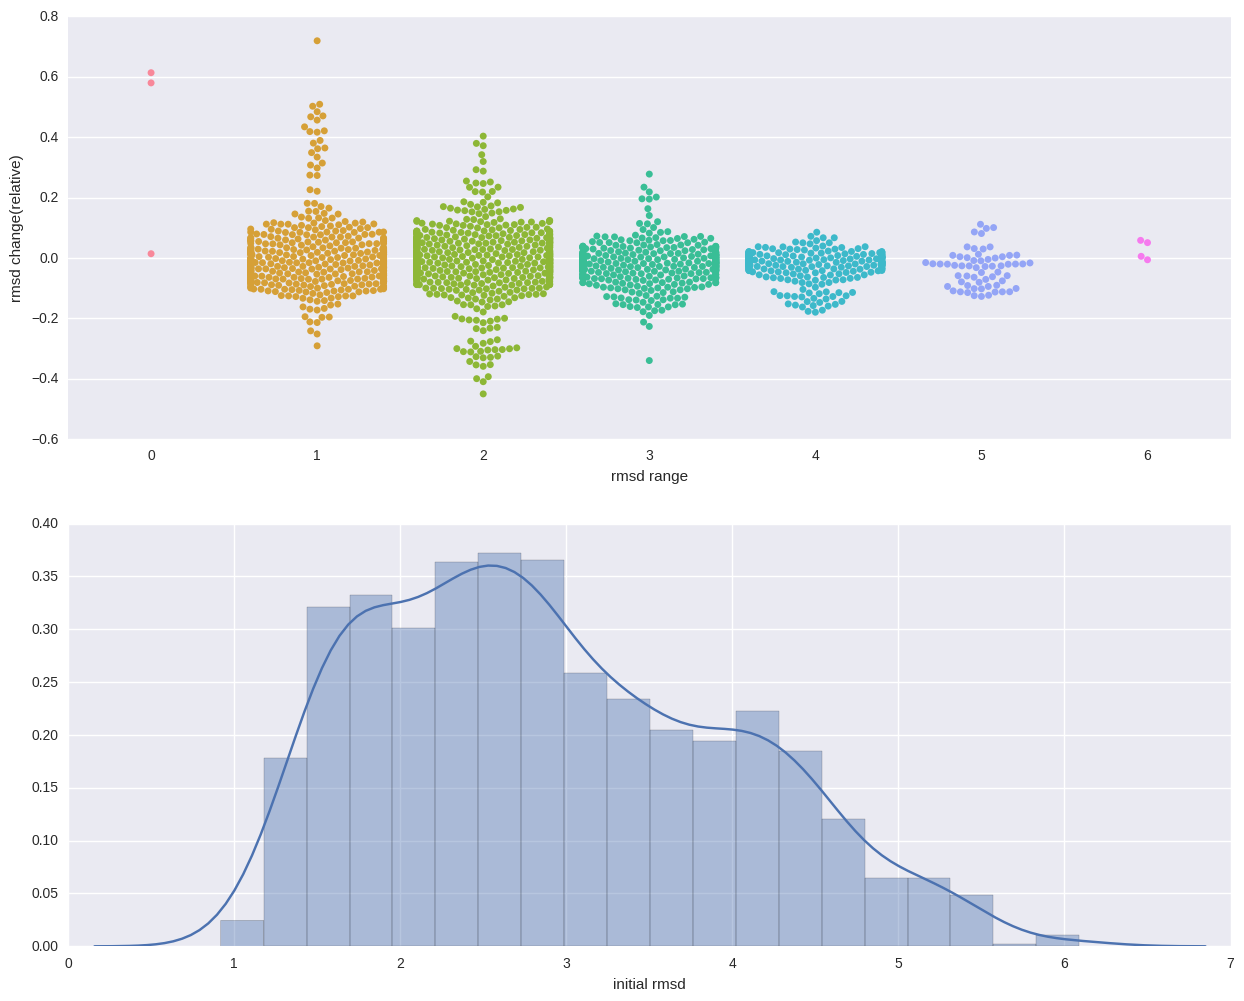

In [112]:
plt.figure(figsize=(15, 12))

plt.subplot(211)
sns.swarmplot(rmsdred[2].apply(int), (rmsdred[3] - rmsdred[2]) / rmsdred[2])
plt.xlabel("rmsd range")
plt.ylabel("rmsd change(relative)")

plt.subplot(212)
sns.distplot(rmsdred[2])
plt.xlabel("initial rmsd")

In [53]:
groups = rmsdred.groupby(0)
pdblist = groups.groups.keys()

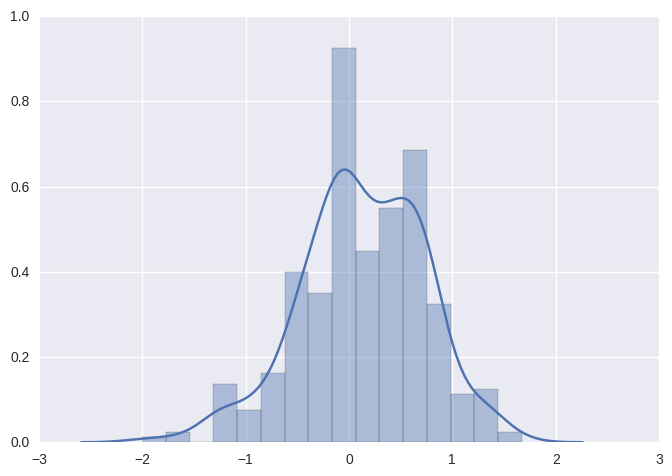

In [113]:
corr_was = []
corr_now = []
for pdb in pdblist:
    group = groups.get_group(pdb)
    minv = min(group[3])
    maxv = max(group[3])
    rng  = maxv - minv
    rmsd_was = list((group[3] - minv) / rng)
    corr_was.append(np.corrcoef(rmsd_was, range(group.shape[0]))[0, 1])
    
    group = group.sort_values(4)
    minv = min(group[3])
    maxv = max(group[3])
    rng  = maxv - minv
    rmsd_now = list((group[3] - minv) / rng)
    corr_now.append(np.corrcoef(rmsd_now, range(group.shape[0]))[0, 1])

sns.distplot(np.array(corr_now) - np.array(corr_was))

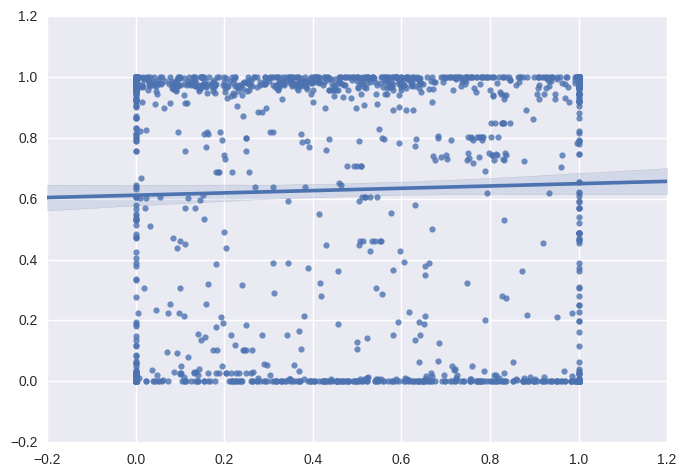

In [114]:
rmsd = []
energy = []
for pdb in pdblist:
    group = groups.get_group(pdb)
    minv = min(group[3])
    maxv = max(group[3])
    rng  = maxv - minv
    rmsd += list((group[3] - minv) / rng)
    
    minv = min(group[4])
    maxv = max(group[4])
    rng  = maxv - minv
    energy += list((group[4] - minv) / rng)

sns.regplot(np.array(rmsd), np.array(energy), fit_reg=True);

In [ ]:
rmsdred = pd.read_csv("../sandbox/mutated_rosetta_refinement/rmsd.txt", sep="\t", header=None)
groups = rmsdred.groupby(0)
pdblist = groups.groups.keys()

nbins = 6
fun = lambda x: int(x) if x < nbins and x > 0 else nbins-1
bins = ["%s-%s" % (str(x), str(x+1)) for x in range(nbins)]
toplot = pd.DataFrame([[np.nan]*4]*len(pdblist)*5)
index = 0
for pdb in pdblist:
    group = groups.get_group(pdb)
    group = group.sort_values(1)
    initial = group[group[1].str.contains("^mutated[0-4]\.pdb$", regex=True)]
    refined = group[group[1].str.contains("^mutated[0-4]_min.+pdb$", regex=True)]
    refined = np.array(refined[2])
    initial = np.array(initial[2])[:len(refined)]

    cols = list(map(fun, initial))
    for bn, rng, val in zip(cols, (refined - initial) / initial, initial):
        toplot.iloc[index, :] = [pdb, bins[bn], rng, val]
        index += 1

toplot[4] = range(5) * (toplot.shape[0] / 5) 

sns.swarmplot(x=1, y=2, data=toplot, order=bins);
plt.xlabel("Initial RMSD");

In [ ]:
rank = 0
sum(toplot[toplot[4] == rank][2] < 0) / float(sum(toplot[toplot[4] == rank][2] > 0))
(toplot[toplot[4] == rank][3] * (1 + toplot[toplot[4] == rank][2])).mean()

In [ ]:
ll = []
for pdb in pdblist:
    group = groups.get_group(pdb)
    group = group[group[1].str.contains("min") == False]
    col = group.sort_values(2, ascending=True)[1]
    
    name = col.iloc[0]
    idx = int(name[7])
    ll.append(idx)

In [ ]:
sns.distplot(toplot[3].dropna())